In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from typing import List
from tqdm import tqdm

In [2]:
# !pip install implicit

In [3]:
from google.colab import drive


#распаковать данные и провести анализ

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
df_users = pd.read_csv('/content/drive/MyDrive/2025Mag2/RecSys/DataSet/users.csv')
df_items = pd.read_csv('/content/drive/MyDrive/2025Mag2/RecSys/DataSet/items.csv')
df_interactions = pd.read_csv('/content/drive/MyDrive/2025Mag2/RecSys/DataSet/interactions.csv')

In [6]:
df_users = df_users.head(int(len(df_users)/5))
df_items = df_items.head(int(len(df_items)/5))

In [7]:
# df_users = pd.read_csv('/content/users.csv')
# df_items = pd.read_csv('/content/items.csv')
# df_interactions = pd.read_csv("/content/interactions.csv")

# df_interactions = df_interactions.head(int(len(df_interactions)/2))

In [8]:
df_items.head(5)

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
0,10711,film,Поговори с ней,Hable con ella,2002.0,"драмы, зарубежные, детективы, мелодрамы",Испания,NaN,16.0,NaN,Педро Альмодовар,"Адольфо Фернандес, Ана Фернандес, Дарио Гранди...",Мелодрама легендарного Педро Альмодовара «Пого...,"Поговори, ней, 2002, Испания, друзья, любовь, ..."
1,2508,film,Голые перцы,Search Party,2014.0,"зарубежные, приключения, комедии",США,NaN,16.0,NaN,Скот Армстронг,"Адам Палли, Брайан Хаски, Дж.Б. Смув, Джейсон ...",Уморительная современная комедия на популярную...,"Голые, перцы, 2014, США, друзья, свадьбы, прео..."
2,10716,film,Тактическая сила,Tactical Force,2011.0,"криминал, зарубежные, триллеры, боевики, комедии",Канада,NaN,16.0,NaN,Адам П. Калтраро,"Адриан Холмс, Даррен Шалави, Джерри Вассерман,...",Профессиональный рестлер Стив Остин («Все или ...,"Тактическая, сила, 2011, Канада, бандиты, ганг..."
3,7868,film,45 лет,45 Years,2015.0,"драмы, зарубежные, мелодрамы",Великобритания,NaN,16.0,NaN,Эндрю Хэй,"Александра Риддлстон-Барретт, Джеральдин Джейм...","Шарлотта Рэмплинг, Том Кортни, Джеральдин Джей...","45, лет, 2015, Великобритания, брак, жизнь, лю..."
4,16268,film,Все решает мгновение,NaN,1978.0,"драмы, спорт, советские, мелодрамы",СССР,NaN,12.0,Ленфильм,Виктор Садовский,"Александр Абдулов, Александр Демьяненко, Алекс...",Расчетливая чаровница из советского кинохита «...,"Все, решает, мгновение, 1978, СССР, сильные, ж..."


In [9]:
df_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3192 entries, 0 to 3191
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   item_id       3192 non-null   int64  
 1   content_type  3192 non-null   object 
 2   title         3192 non-null   object 
 3   title_orig    2215 non-null   object 
 4   release_year  3172 non-null   float64
 5   genres        3192 non-null   object 
 6   countries     3183 non-null   object 
 7   for_kids      99 non-null     float64
 8   age_rating    3192 non-null   float64
 9   studios       221 non-null    object 
 10  directors     2904 non-null   object 
 11  actors        2702 non-null   object 
 12  description   3191 non-null   object 
 13  keywords      3100 non-null   object 
dtypes: float64(3), int64(1), object(10)
memory usage: 349.3+ KB


In [10]:
df_users.head(5)

,user_id,age,income,sex,kids_flg
0,973171,age_25_34,income_60_90,М,1
1,962099,age_18_24,income_20_40,М,0
2,1047345,age_45_54,income_40_60,Ж,0
3,721985,age_45_54,income_20_40,Ж,0
4,704055,age_35_44,income_60_90,Ж,0


In [11]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168039 entries, 0 to 168038
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   168039 non-null  int64 
 1   age       165245 non-null  object
 2   income    165152 non-null  object
 3   sex       165323 non-null  object
 4   kids_flg  168039 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 6.4+ MB


In [12]:
df_interactions['last_watch_dt'] = pd.to_datetime(df_interactions['last_watch_dt'])
print(len(df_interactions))
df_interactions.drop(df_interactions.tail(1).index,inplace=True)
print(len(df_interactions))
df_interactions = df_interactions.assign(reallyWatched = df_interactions['watched_pct'] >= 10.0)

5476251
5476250


In [13]:
uniq_users = df_users['user_id'].unique()
uniq_items = df_items['item_id'].unique()

In [14]:
len(df_interactions)

5476250

In [15]:
df_interactions = df_interactions[df_interactions['user_id'].isin(df_users['user_id']) & df_interactions['item_id'].isin(df_items['item_id'])]

In [16]:
len(df_interactions)

197782

In [17]:
df_interactions.head(5)

,user_id,item_id,last_watch_dt,total_dur,watched_pct,reallyWatched
48,568405,15297,2021-07-30,15298,100.0,True
83,154102,12299,2021-08-01,940,12.0,True
145,141072,7308,2021-07-10,8657,100.0,True
157,827032,6979,2021-05-26,6133,100.0,True
190,741742,7107,2021-05-16,11,0.0,False


In [18]:
df_interactions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 197782 entries, 48 to 5476218
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        197782 non-null  int64         
 1   item_id        197782 non-null  int64         
 2   last_watch_dt  197782 non-null  datetime64[ns]
 3   total_dur      197782 non-null  int64         
 4   watched_pct    197781 non-null  float64       
 5   reallyWatched  197782 non-null  bool          
dtypes: bool(1), datetime64[ns](1), float64(1), int64(3)
memory usage: 9.2 MB


#Сформировать набор данных

In [19]:
# параметр K
k = 10

test_size_days = 7
dateColumnName = "last_watch_dt"
userColumnName = "user_id"
watchdPrcntColumnName = "watched_pct"
itemIdColumnName = "item_id"
totalDurColumnName = "total_dur"
reallyWatchedColumn = "reallyWatched"

In [20]:
from datetime import datetime, timedelta

# Получение даты с которой начинается тестовый набор
def getLastWeekFirstDay(lastDate, test_size_days=7):
    return lastDate - timedelta(days=(test_size_days-1))

In [21]:
# получение тренировочного и тестового наборов по дням
def splitByLastDate(df_interactions, test_size_days = 7):
  # Получаем последнюю дату
  maxDate = df_interactions[dateColumnName].max()
  lastWeekFirstDate = getLastWeekFirstDay(maxDate, test_size_days)
  print(lastWeekFirstDate)
  data_train = df_interactions[df_interactions[dateColumnName] < lastWeekFirstDate]
  data_test = df_interactions[df_interactions[dateColumnName] >= lastWeekFirstDate]
  return data_train, data_test

In [22]:
df_interactions_train, df_interactions_test = splitByLastDate(df_interactions, test_size_days)

2021-08-16 00:00:00


In [23]:
df_interactions_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13762 entries, 438 to 5475997
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   user_id        13762 non-null  int64         
 1   item_id        13762 non-null  int64         
 2   last_watch_dt  13762 non-null  datetime64[ns]
 3   total_dur      13762 non-null  int64         
 4   watched_pct    13762 non-null  float64       
 5   reallyWatched  13762 non-null  bool          
dtypes: bool(1), datetime64[ns](1), float64(1), int64(3)
memory usage: 658.5 KB


In [24]:
df_interactions_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 184020 entries, 48 to 5476218
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        184020 non-null  int64         
 1   item_id        184020 non-null  int64         
 2   last_watch_dt  184020 non-null  datetime64[ns]
 3   total_dur      184020 non-null  int64         
 4   watched_pct    184019 non-null  float64       
 5   reallyWatched  184020 non-null  bool          
dtypes: bool(1), datetime64[ns](1), float64(1), int64(3)
memory usage: 8.6 MB


In [25]:
def filter_userInteractions(df):
  # df_Temp = df.copy()
  # df_Temp["grouped"] = df.groupby(userColumnName)[itemIdColumnName].unique().reset_index()
  df_Temp = df.groupby(userColumnName)[itemIdColumnName].unique().reset_index()
  df_Temp.columns = [userColumnName, itemIdColumnName]
  filtered_df_Temp = df_Temp[df_Temp[itemIdColumnName].apply(lambda x: len(x)>2)]
  unique_users = filtered_df_Temp[userColumnName].unique()
  print(len(unique_users))
  print(filtered_df_Temp.head())
  print(df.head())
  return df[df[userColumnName].isin(unique_users)]



In [26]:
df_interactions_train_orig = df_interactions_train.copy()
df_interactions_test_orig = df_interactions_test.copy()

In [27]:
df_interactions_train = filter_userInteractions(df_interactions_train_orig)


20544
    user_id                      item_id
6        46  [15399, 12245, 4880, 10440]
7        53         [7571, 15297, 10440]
12      131  [10440, 12096, 6501, 15297]
17      175        [10440, 12812, 15297]
18      191         [10732, 11756, 4878]
     user_id  item_id last_watch_dt  total_dur  watched_pct  reallyWatched
48    568405    15297    2021-07-30      15298        100.0           True
83    154102    12299    2021-08-01        940         12.0           True
145   141072     7308    2021-07-10       8657        100.0           True
157   827032     6979    2021-05-26       6133        100.0           True
190   741742     7107    2021-05-16         11          0.0          False


In [28]:
df_interactions_test = filter_userInteractions(df_interactions_test_orig)

757
    user_id                     item_id
12     1140  [3306, 8140, 14916, 13615]
29     3272         [7476, 11216, 5732]
34     4085        [14111, 6668, 10994]
36     4176        [11018, 14087, 4880]
46     5477  [10515, 7571, 1743, 10797]
      user_id  item_id last_watch_dt  total_dur  watched_pct  reallyWatched
438    711018    16228    2021-08-21       1963          3.0          False
633     73094    15297    2021-08-20      16643         88.0           True
647    663761    15297    2021-08-19        636          0.0          False
869    323487    10774    2021-08-19        805        100.0           True
1507   864272     5453    2021-08-19          9          0.0          False


In [29]:
df_interactions_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2823 entries, 3609 to 5474168
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   user_id        2823 non-null   int64         
 1   item_id        2823 non-null   int64         
 2   last_watch_dt  2823 non-null   datetime64[ns]
 3   total_dur      2823 non-null   int64         
 4   watched_pct    2823 non-null   float64       
 5   reallyWatched  2823 non-null   bool          
dtypes: bool(1), datetime64[ns](1), float64(1), int64(3)
memory usage: 135.1 KB


In [30]:
df_interactions_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 107245 entries, 83 to 5476218
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        107245 non-null  int64         
 1   item_id        107245 non-null  int64         
 2   last_watch_dt  107245 non-null  datetime64[ns]
 3   total_dur      107245 non-null  int64         
 4   watched_pct    107244 non-null  float64       
 5   reallyWatched  107245 non-null  bool          
dtypes: bool(1), datetime64[ns](1), float64(1), int64(3)
memory usage: 5.0 MB


In [31]:
df_interactions_test.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct,reallyWatched
3609,812384,16087,2021-08-21,2013,31.0,True
8990,228025,5411,2021-08-21,812,15.0,True
11605,424980,16152,2021-08-16,16,0.0,False
13064,340304,3463,2021-08-20,1031,16.0,True
13312,757876,2500,2021-08-16,48,1.0,False


In [32]:
# достать уникальных пользователей из train
train_unique_users = df_interactions_train[userColumnName].unique()
test_unique_users = df_interactions_test[userColumnName].unique()

test_unique_items = df_interactions_test[itemIdColumnName].unique()
train_unique_items = df_interactions_train[itemIdColumnName].unique()

In [33]:
len(test_unique_users)

757

In [34]:
# отфильтровать валидные случаи
user_tests_content_interaction = df_interactions_test[((df_interactions_test[reallyWatchedColumn] == True))]

In [35]:
user_tests_content_interaction_Really = df_interactions_test[((df_interactions_test[reallyWatchedColumn] == True))]
user_train_content_interaction_Really = df_interactions_train[((df_interactions_train[reallyWatchedColumn] == True))]

In [36]:
test_unique_items_really = user_tests_content_interaction_Really[itemIdColumnName].unique()
train_unique_items_really = user_train_content_interaction_Really[itemIdColumnName].unique()

In [37]:
user_tests_content_interaction = df_interactions_test.groupby(userColumnName)[itemIdColumnName].unique().reset_index()

In [38]:
user_tests_content_interaction.columns = [userColumnName, itemIdColumnName]

In [39]:
user_tests_content_interaction

,user_id,item_id
0,1140,"[3306, 8140, 14916, 13615]"
1,3272,"[7476, 11216, 5732]"
2,4085,"[14111, 6668, 10994]"
3,4176,"[11018, 14087, 4880]"
4,5477,"[10515, 7571, 1743, 10797]"
...,...,...
752,1090766,"[1333, 9352, 9787, 14916, 8140]"
753,1092910,"[8986, 11756, 13464, 16087, 427, 12502]"
754,1094883,"[13018, 6785, 2408, 7311, 13317, 7571, 8140]"
755,1095014,"[11697, 6006, 3768]"


In [40]:
filtered_user_tests_content_interaction = user_tests_content_interaction[user_tests_content_interaction[itemIdColumnName].apply(lambda x: len(x)>1)]


In [41]:
filtered_user_tests_content_interaction

,user_id,item_id
0,1140,"[3306, 8140, 14916, 13615]"
1,3272,"[7476, 11216, 5732]"
2,4085,"[14111, 6668, 10994]"
3,4176,"[11018, 14087, 4880]"
4,5477,"[10515, 7571, 1743, 10797]"
...,...,...
752,1090766,"[1333, 9352, 9787, 14916, 8140]"
753,1092910,"[8986, 11756, 13464, 16087, 427, 12502]"
754,1094883,"[13018, 6785, 2408, 7311, 13317, 7571, 8140]"
755,1095014,"[11697, 6006, 3768]"


In [42]:
len(filtered_user_tests_content_interaction)

757

In [43]:
def precision(recommended_list, bought_list):

    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)

    flags = np.isin(bought_list, recommended_list)

    precision = flags.sum() / len(recommended_list)

    return precision


def precision_at_k(recommended_list, bought_list, k=5):

    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)

    #assert len(bought_list) > len(recommended_list)
    bought_list = bought_list  # Тут нет [:k] !!
    recommended_list = recommended_list[:k]

    flags = np.isin(bought_list, recommended_list)

    precision = flags.sum() / len(recommended_list)


    return precision


def money_precision_at_k(recommended_list, bought_list, prices_recommended, k=5):

    # your_code
    # Лучше считать через скалярное произведение, а не цикл
    bought_list = bought_list  # Тут нет [:k] !!
    recommended_list = recommended_list[:k]

    flags = np.isin(bought_list, recommended_list)

    precision = np.dot(flags, bought_list) / np.sum(recommended_list)
    return precision

In [44]:
def recall(recommended_list, bought_list):

    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)

    flags = np.isin(bought_list, recommended_list)

    recall = flags.sum() / len(bought_list)

    return recall


def recall_at_k(recommended_list, bought_list, k=5):

    # your_code
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list[:k])

    flags = np.isin(bought_list, recommended_list)

    recall = flags.sum() / len(bought_list)

    return recall


def money_recall_at_k(recommended_list, bought_list, prices_recommended, prices_bought, k=5):

    # your_code
    bought_list = np.array(bought_list)
    recommended_list = recommended_list[:k]

    flags = np.isin(bought_list, recommended_list)

    recall = np.dot(flags, bought_list) / np.sum(bought_list)

    return recall

In [45]:
def ap_k(recommended_list, bought_list, k=5):
    # print("=",bought_list, recommended_list)
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)
    flags = np.isin(recommended_list, bought_list)
    # if (np.isin([True],flags)[0]):
    #   print(flags)
    if sum(flags) == 0:
        return 0

    sum_ = 0
    for i in range(0, k-1):
        if flags[i] == True:
            p_k = precision_at_k(recommended_list, bought_list, k=i+1)
            sum_ += p_k

    result = sum_ / sum(flags)

    return result

In [46]:
# получение списка взаимодействий юзера
def getUserItems(userInteractionItems, user_id):
  return userInteractionItems[(userInteractionItems[userColumnName] == user_id)][itemIdColumnName].values[0]

In [47]:
# получение значения из матрицы по двум столбцам
def getColFromBy2Col(Items, first_column, second_column, first_c_id):
  return Items[(Items[first_column] == first_c_id)][second_column]

In [48]:
# получение значения из матрицы по двум столбцам
def getValueFromBy2Col(Items, first_column, second_column, first_c_id):
  colFromBy2Col = getColFromBy2Col(Items, first_column, second_column, first_c_id)
  # print(colFromBy2Col)
  if len(colFromBy2Col) > 0:
    return colFromBy2Col.values[0]
  else:
    return None

#random

In [49]:
# def getRandomRecommendOLD(items, k=10):
#   return items[itemIdColumnName].sample(k,replace=True).tolist()

# def getRandomRecommendOLDOLD(items, k=10):
#   return pd.Series(items[itemIdColumnName].unique()).sample(k,replace=True).tolist()

def getRandomRecommend(items, k=10):
  return np.random.choice(items, k)

In [50]:
def getFirstK(items, k=10):
  return items[:k]

In [51]:
# item = рекомендации взять из тестового набора
def map_k(items, userContentInteractions, func, k=10):
    user_ids = userContentInteractions[userColumnName].tolist()
    result = [ap_k(func(items, k), getUserItems(userContentInteractions, i)) for i in user_ids]
    return np.average(result)

#popular

In [52]:
# Получение популярных items по всем
def getPopularItems(df):
  items_content_interaction_Pop = df.groupby(itemIdColumnName)[watchdPrcntColumnName].unique().reset_index()
  items_content_interaction_Pop.columns = [itemIdColumnName, watchdPrcntColumnName]
  items_content_interaction_Pop[watchdPrcntColumnName] = items_content_interaction_Pop[watchdPrcntColumnName].apply(lambda x: len(np.array(x)))
  items_content_interaction_Pop = items_content_interaction_Pop.sort_values(by=watchdPrcntColumnName, ascending=False)
  return items_content_interaction_Pop[itemIdColumnName].unique()

#Popular+UPopular

In [53]:
def sumColVal(x):
  print(x)
  return (len(x[1]))

#ЗАДАЧА 2

In [54]:
all_users = df_interactions[userColumnName].unique()


In [55]:
# получить интеракции пользователя
def get_user_interactions(user_id, df_interactions):
  return df_interactions[((df_interactions[userColumnName] == user_id))]

def getUniqueColumnValues(df, columnName):
  return df[columnName].unique()

In [56]:
import random

#Получение случайного пользователя со списком взаимодействий > k
def getRandomUser(df_interactions, k = 10):
  random_user_interactions = []
  while len(random_user_interactions) < k:
    random_user = random.choice(all_users)
    random_user_interactions = get_user_interactions(random_user, df_interactions)
  return random_user_interactions

In [57]:
# получение строк только по вхождениям из списка
def getitemsByList(df,columnName, list_of_users):
  return df[df[columnName].isin(list_of_users)]

In [58]:
releaseYearCol = 'release_year'
genresCol = 'genres'
actorsCol = 'actors'
directorsCol = 'directors'

In [59]:
def getArrayFromDF(df, columnName):
  return df[columnName].apply(lambda x: x.split(', '))

In [60]:
# Условия для itemXitem

# тот-же год
def sameYearDF(df, year):
  conditions = [
    (df[releaseYearCol] == year),
    (df[releaseYearCol] != year)
  ]
  choices = [0.25, 0]
  return np.select(conditions, choices)

# Хотя бы один жанр
def sameGenreDF(df, genres):
  conditions = [
    (df[genresCol].str.contains('|'.join(genres)) == True),
    (df[genresCol].str.contains('|'.join(genres)) != True)
  ]
  choices = [0.25, 0]
  return np.select(conditions, choices)

# Хотя бы один актер
def sameActorDF(df, actors):
  conditions = [
    (df[actorsCol].str.contains('|'.join(actors)) == True),
    (df[actorsCol].str.contains('|'.join(actors)) != True)
  ]
  choices = [0.25, 0]
  return np.select(conditions, choices)

# Хотя бы один режиссер
def sameDirectorDF(df, directors):
  conditions = [
    (df[directorsCol].str.contains('|'.join(directors)) == True),
    (df[directorsCol].str.contains('|'.join(directors)) != True)
  ]
  choices = [0.25, 0]
  return np.select(conditions, choices)

##############################################
# Условия для userXitem

# # Сравнить по проценту просмотренного
# def compareWatchedDF(df, watchPrcnt):
#   conditions = [
#     (df[watchdPrcntColumnName] >= watchPrcnt),
#     (df[watchdPrcntColumnName] < watchPrcnt)
#   ]
#   choices = [1, 0]
#   return np.select(conditions, choices)

# Сравнить по проценту просмотренного и по диапазону дат (и по полу пользователя)
def sameDateWatchedDF(df, df_u, time_from, time_to, watchPrcnt, sex):
  conditions = [
    ((df[dateColumnName] > time_from) & (df[dateColumnName] < time_to) & (df[watchdPrcntColumnName] >= 15.0) & (df_u['sex'] == sex) == True),
    ((df[dateColumnName] > time_from) & (df[dateColumnName] < time_to) & (df[watchdPrcntColumnName] >= 15.0) & (df_u['sex'] == sex) != True)
  ]
  choices = [1, 0]
  return np.select(conditions, choices)

# # Сравнить по проценту просмотренного и по диапазону дат
# def similarUser(df, sex):



In [61]:
def getCoeff(b,itemId, c = 0.25):
  # b.replace(np.nan, False, inplace=True)
  # print(c if b.get(itemId) else 0)
  # print(b.size)
  return c if b.get(itemId) == True else 0

In [62]:
def convertToArray(df, col1, col2, id):
  data = getValueFromBy2Col(df, col1, col2, id)
  return data.split(', ') if type(data) == 'str'else []


#ALS

In [134]:

import sys
# путь до папки с py файлами на диске
sys.path.append('/content/drive/MyDrive/2025Mag2/RecSys/RecSysFiles')

In [135]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import polars as pl
from datetime import datetime, timedelta

import time
from tqdm import tqdm
from metrics import ap_k
from als import ALS
from datagenerator import  DataGenerator

from scipy.sparse import csr_matrix
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr


In [152]:
# Нужно оставить только необходимые столбики и преобразовать в массив (с батчами)
# матрица userXrating составляется так-же как в KNN

In [153]:
!pip install scipy

In [154]:
from scipy.sparse import csr_matrix, coo_matrix
from pyspark.ml.recommendation import ALS


In [156]:
from sklearn.model_selection import train_test_split
# df_train_3, df_test_3 = train_test_split(df_interactions, test_size=0.2)
df_train_3 = df_interactions_train.copy()
df_test_3 = df_interactions_test.copy()


In [157]:
df_train_3

,user_id,item_id,last_watch_dt,total_dur,watched_pct,reallyWatched
83,154102,12299,2021-08-01,940,12.0,True
145,141072,7308,2021-07-10,8657,100.0,True
251,752541,16029,2021-04-26,9308,100.0,True
284,37298,7107,2021-05-08,147,25.0,True
314,1039379,747,2021-08-05,357,6.0,False
...,...,...,...,...,...,...
5476053,32256,11756,2021-08-01,10892,100.0,True
5476120,182577,16447,2021-06-26,14,0.0,False
5476150,1089663,14111,2021-05-23,81,1.0,False
5476205,381343,13072,2021-05-22,13122,100.0,True


In [161]:
def colByUserAndItem(y, c, d, itemId):
  print(itemId)
  return c if y == itemId else d

In [166]:
def getUserInteracPd(df3_interactions, df3_users, df3_items):
  arrr = df3_interactions

  user_item_3_df = pd.DataFrame(df3_users, columns = [userColumnName])
  print(len(df3_users), len(df3_items))
  counter = 0
  for item_id in df3_items:
    counter +=1
    # watched = getValueFromBy2Col(df_items, itemIdColumnName, genresCol, itemId).split(", ")
    # print(item_id)
    conditions = [
      (arrr[itemIdColumnName] == item_id),
      (arrr[itemIdColumnName] != item_id)
    ]
    choices = [arrr[watchdPrcntColumnName], 0]
    values_uI = pd.Series(choices)
    user_item_3_df = pd.concat([user_item_3_df, values_uI.rename(item_id)], axis=1)
    # if (counter % 100 == 0):
    print('_____________________',counter, ' /  ', len(df3_items))    # user_item_3_df[item_id] = np.select(conditions, choices)# colByUserAndItem(df3_interactions[itemIdColumnName], df3_interactions[watchdPrcntColumnName], df3_interactions[naCol], item_id) #df3_interactions.apply(lambda row: colByUserAndItem(row[itemIdColumnName], row[watchdPrcntColumnName], row[naCol], item_id), axis=1)

  # shape = (len(df3_users), len(df3_items))

  # # Create indices for df3_users and items
  # # user_cat = CategoricalDtype(categories=sorted(df3_users), ordered=True)
  # # item_cat = CategoricalDtype(categories=sorted(df3_items), ordered=True)
  # # user_index = df3_interactions[userColumnName].astype(user_cat).cat.codes
  # # item_index = df3_interactions[itemIdColumnName].astype(item_cat).cat.codes


  # data_interac = np.empty(0)
  # user_index = np.empty(0)
  # item_index = np.empty(0)
  # for u_id in df3_users:
  #   for i_id in df3_items:
  #     value = df3_interactions.loc[(df3_interactions[userColumnName] == u_id) & (df3_interactions[itemIdColumnName] == i_id)][watchdPrcntColumnName].unique()
  #     if len(value) > 0:
  #       data_interac = np.append(data_interac, value[0])
  #       user_index = np.append(user_index, u_id)
  #       item_index = np.append(item_index, i_id)

  # print(user_index, item_index)
  # # Conversion via COO matrix
  # coo = coo_matrix((data_interac, (user_index, item_index)), shape=shape)
  return user_item_3_df

In [173]:
def createMapByValues(arr):
  m = {}
  for idx, val in enumerate(arr):
    m[val] = idx
  return m


In [175]:
def changeArrValsToMapVal(arr, m):
  # print(arr, len(m))
  return [m[np.int64(x)] for x in arr]

In [176]:
def getUserInterac(df3_items, df3_users, df3_interactions):
  # user_item_3_df = pd.DataFrame(df3_users, columns = [userColumnName])

  # for item_id in df3_items:
  #   # watched = getValueFromBy2Col(df_items, itemIdColumnName, genresCol, itemId).split(", ")
  #   # print(item_id)
  #   conditions = [
  #     (df3_interactions[itemIdColumnName] == item_id),
  #     (df3_interactions[itemIdColumnName] != item_id)
  #   ]
  #   choices = [df3_interactions[watchdPrcntColumnName], 0]

  #   user_item_3_df[item_id] = np.select(conditions, choices)# colByUserAndItem(df3_interactions[itemIdColumnName], df3_interactions[watchdPrcntColumnName], df3_interactions[naCol], item_id) #df3_interactions.apply(lambda row: colByUserAndItem(row[itemIdColumnName], row[watchdPrcntColumnName], row[naCol], item_id), axis=1)

  shape = (len(df3_users), len(df3_items))

  # Create indices for df3_users and items
  # user_cat = CategoricalDtype(categories=sorted(df3_users), ordered=True)
  # item_cat = CategoricalDtype(categories=sorted(df3_items), ordered=True)
  # user_index = df3_interactions[userColumnName].astype(user_cat).cat.codes
  # item_index = df3_interactions[itemIdColumnName].astype(item_cat).cat.codes

  itemsMap = createMapByValues(df3_items)
  usersMap = createMapByValues(df3_users)

  data_interac = np.empty(0)
  user_index = np.empty(0)
  item_index = np.empty(0)
  df_smal = df3_interactions.copy()
  df_smal = df_smal[[userColumnName, itemIdColumnName, watchdPrcntColumnName]]
  counter = 0

  for i_id in df3_items:
    counter += 1
    df_filtered = df_smal[df_smal[itemIdColumnName] == i_id]
    item_users = changeArrValsToMapVal(df_filtered[userColumnName].unique(), usersMap)
    item_watched = df_filtered[watchdPrcntColumnName].tolist()

    # for u_id in df3_users:
    #   value = df3_interactions.loc[(df3_interactions[userColumnName] == u_id) & (df3_interactions[itemIdColumnName] == i_id)][watchdPrcntColumnName].unique()
    if len(item_watched) > 0:
        item_interac = np.full(len(item_watched), itemsMap[i_id])
        # print(len(item_watched), len(item_users), len(item_interac))
        data_interac = np.append(data_interac, item_watched)
        user_index = np.append(user_index, item_users)
        item_index = np.append(item_index, item_interac)
    if counter % 100 == 0:
      print('_____________________',counter, ' /  ', len(df3_items))    # user_item_3_df[item_id] = np.select(conditions, choices)# colByUserAndItem(df3_interactions[itemIdColumnName], df3_interactions[watchdPrcntColumnName], df3_interactions[naCol], item_id) #df3_interactions.apply(lambda row: colByUserAndItem(row[itemIdColumnName], row[watchdPrcntColumnName], row[naCol], item_id), axis=1)

  print(user_index, item_index)
  # Conversion via COO matrix
  coo = coo_matrix((data_interac, (user_index, item_index)), shape=shape)
  return coo.tocsr()

In [179]:
from pandas.api.types import CategoricalDtype


In [192]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168039 entries, 0 to 168038
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   168039 non-null  int64 
 1   age       165245 non-null  object
 2   income    165152 non-null  object
 3   sex       165323 non-null  object
 4   kids_flg  168039 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 6.4+ MB


In [194]:
ratings_train = getUserInterac(df_items[itemIdColumnName].unique(), df_users[userColumnName].unique(), df_train_3)


_____________________ 100  /   3192
_____________________ 200  /   3192
_____________________ 300  /   3192
_____________________ 400  /   3192
_____________________ 500  /   3192
_____________________ 600  /   3192
_____________________ 700  /   3192
_____________________ 800  /   3192
_____________________ 900  /   3192
_____________________ 1000  /   3192
_____________________ 1100  /   3192
_____________________ 1200  /   3192
_____________________ 1300  /   3192
_____________________ 1400  /   3192
_____________________ 1500  /   3192
_____________________ 1600  /   3192
_____________________ 1700  /   3192
_____________________ 1800  /   3192
_____________________ 1900  /   3192
_____________________ 2000  /   3192
_____________________ 2100  /   3192
_____________________ 2200  /   3192
_____________________ 2300  /   3192
_____________________ 2400  /   3192
_____________________ 2500  /   3192
_____________________ 2600  /   3192
_____________________ 2700  /   3192
__________

In [195]:
itemsMap_3 = createMapByValues(df_items[itemIdColumnName].unique())
usersMap_3 = createMapByValues(df_users[userColumnName].unique())

In [196]:
ratings_test = getUserInterac(df_items[itemIdColumnName].unique(), df_users[userColumnName].unique(), df_test_3)

_____________________ 100  /   3192
_____________________ 200  /   3192
_____________________ 300  /   3192
_____________________ 400  /   3192
_____________________ 500  /   3192
_____________________ 600  /   3192
_____________________ 700  /   3192
_____________________ 800  /   3192
_____________________ 900  /   3192
_____________________ 1000  /   3192
_____________________ 1100  /   3192
_____________________ 1200  /   3192
_____________________ 1300  /   3192
_____________________ 1400  /   3192
_____________________ 1500  /   3192
_____________________ 1600  /   3192
_____________________ 1700  /   3192
_____________________ 1800  /   3192
_____________________ 1900  /   3192
_____________________ 2000  /   3192
_____________________ 2100  /   3192
_____________________ 2200  /   3192
_____________________ 2300  /   3192
_____________________ 2400  /   3192
_____________________ 2500  /   3192
_____________________ 2600  /   3192
_____________________ 2700  /   3192
__________

In [197]:
train_data = ratings_train
test_data = ratings_test

In [198]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import polars as pl
from datetime import datetime, timedelta

import time
from tqdm import tqdm
from metrics import ap_k
from als import ALS
from datagenerator import  DataGenerator

from scipy.sparse import csr_matrix
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr


In [199]:
train_data.shape

(168039, 3192)

In [200]:
# Инициализируем и обучаем модель
print("\n" + "="*50)
als_model_interac = ALS(
        n_factors=10,
        alpha=40,
        regularization=0.1,
        iterations=10
    )


In [201]:
als_model_interac.fit(train_data)


Начинаем обучение ALS...
halfDone------------
calcLoss
Итерация 1/10
halfDone------------
calcLoss
Итерация 2/10
halfDone------------
calcLoss
Итерация 3/10
halfDone------------
calcLoss
Итерация 4/10
halfDone------------
calcLoss
Итерация 5/10
halfDone------------
calcLoss
Итерация 6/10
halfDone------------
calcLoss
Итерация 7/10
halfDone------------
calcLoss
Итерация 8/10
halfDone------------
calcLoss
Итерация 9/10
halfDone------------
calcLoss
Итерация 10/10


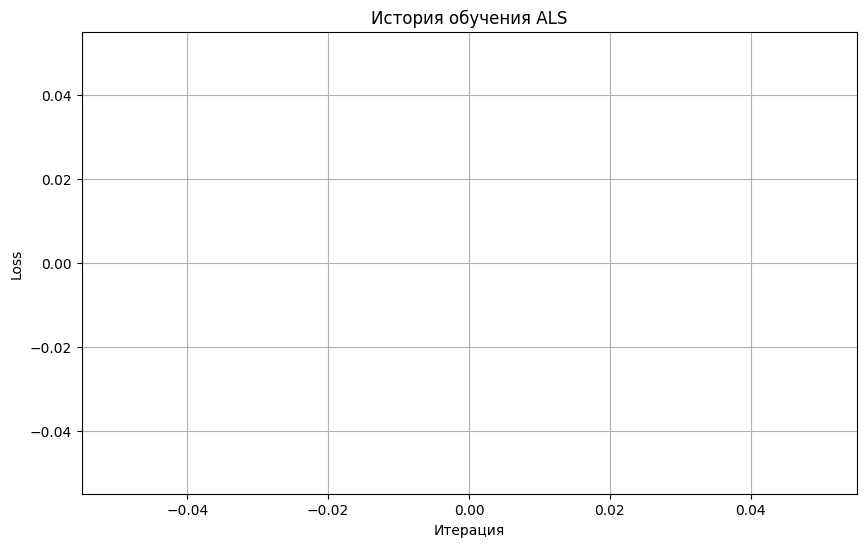


Оценка модели:


In [203]:
# ОТКЛЮЧИЛ LOSS ВЫЧИСЛЕНИЯ, Т.К. СЧИТАЛИСЬ ДОЛГО
# Визуализация процесса обучения
als_model_interac.plot_loss()

# Оценка модели
print("\nОценка модели:")


In [206]:

# Предсказания на тестовой выборке
test_predictions = []
test_actual = []

In [207]:
for u in range(test_data.shape[0]):
    if u % 1000 == 0:
              print(u)
    for i in range(test_data.shape[1]):
        if test_data[u, i] > 0:
                pred = als_model_interac.predict(u, i)
                test_predictions.append(pred)
                test_actual.append(test_data[u, i])

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000


KeyboardInterrupt: 

In [210]:
# Вычисляем метрики
mse = mean_squared_error(test_actual, test_predictions)
rmse = np.sqrt(mse)

print(f"RMSE на тестовой выборке: {rmse:.4f}")

    # Демонстрация рекомендаций
print("\nДемонстрация рекомендаций:")
user_id = 0
recommended_items, scores = als_model_interac.recommend(user_id, n_recommendations=10)

print(f"Топ-10 рекомендаций для пользователя {user_id}:")
for i, (item, score) in enumerate(zip(recommended_items, scores)):
    print(f"{i+1}. Item {item} (score: {score:.3f})")

    # Анализ факторов
print(f"\nАнализ модели:")
print(f"Размерность user_factors: {als_model_interac.user_factors.shape}")
print(f"Размерность item_factors: {als_model_interac.item_factors.shape}")
print(f"Общее количество параметров: {als_model_interac.user_factors.size + als_model_interac.item_factors.size}")


RMSE на тестовой выборке: 62.1458

Демонстрация рекомендаций:
Топ-10 рекомендаций для пользователя 0:
1. Item 1412 (score: 0.216)
2. Item 1369 (score: 0.144)
3. Item 536 (score: 0.124)
4. Item 1327 (score: 0.096)
5. Item 996 (score: 0.092)
6. Item 2923 (score: 0.083)
7. Item 597 (score: 0.078)
8. Item 3180 (score: 0.076)
9. Item 453 (score: 0.074)
10. Item 638 (score: 0.073)

Анализ модели:
Размерность user_factors: (168039, 10)
Размерность item_factors: (3192, 10)
Общее количество параметров: 1712310
